## Using a linear model to predict real estate prices
Michael Vandervelden, 2023

In [2]:
# Import requisite libraries

import asyncio
from typing import List
import httpx
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from urllib.parse import urlencode

from parsel import Selector
pd.set_option('display.max_rows', 50)

In [12]:
client = httpx.AsyncClient(
    http2=True,
    headers={
        "accept-language": "en-US,en;q=0.9",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "accept-language": "en-US;en;q=0.9",
        "accept-encoding": "gzip, deflate, br",
    },
)

Here we store the latitude and longitude values for each borough, as well as the search term strings needed for each borough. These will later be passed as parameters to the scraping/data cleaning function defined below. 

In [106]:
brooklyn_coords = {"west":-74.28887284228514,"east":-74.01902115771483,"south":40.49361654444022,"north":40.65112924425314,}
bronx_coords = {"west":-74.2075666845703, "east":-73.66786331542967, "south":40.49753808454121,"north":40.812174096474955,}
manhattan_coords = {"west":-74.24867418457029, "east":-73.70897081542967,"south":40.62357275516118,"north":40.93761504703568,}
statenisland_coords = {"west":-74.255641,"east":-74.052253,"south":40.495865,"north":40.648886,}
queens_coords =  {"west":-73.962632,"east":-73.700272,"south":40.541722,"north":40.80071,}



brooklyn_search = "Brookyln NY New New York"
bronx_search = "Bronx NY New York"
manhattan_search = "Manhattan NY New York"
statenisland_search = "Staten Island NY New York"
queens_search = "Queens NY New York"

Function to scrape and perform initial cleaning of Zillow data depending for each New York City borough 

In [107]:
def get_and_clean_borough_data(location_dict, location_name):
    BASE_HEADERS = {

        "accept-language": "en-US,en;q=0.9",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "accept-language": "en-US;en;q=0.9",
        "accept-encoding": "gzip, deflate, br",
    }

    url = "https://www.zillow.com/search/GetSearchPageState.htm?"



    # Search parameters
    parameters = {
        "searchQueryState": {
            "pagination": {},
            "usersSearchTerm": location_name,
            
            "mapBounds": location_dict,

        },
        "wants": {
            "cat1": ["listResults", "mapResults"], "cat2": ["total"]
        },
        "requestId": 2,
    }
    response = httpx.get(url + urlencode(parameters), headers=BASE_HEADERS)
    assert response.status_code == 200, "request has been blocked"
    data = response.json()
    results = response.json()["cat1"]["searchResults"]["mapResults"]
    data_list = json.dumps(results, indent=2)
    df = pd.read_json(data_list)
    
    borough_df = df.drop(df.iloc[:, 7:], axis=1)
    
    
    borough_df = borough_df.drop(columns=['zpid', 'rentalMarketingSubType','priceLabel'])
        
    
    borough_df = borough_df.dropna()
    
    borough_df['price'] = borough_df['price'].apply(lambda x: re.sub('[$,KFrom]', '', x))
    borough_df['beds'] = borough_df['beds'].apply(lambda x: int(x))
    borough_df['baths'] = borough_df['baths'].apply(lambda x: int(x))
    

    return borough_df
        

Creating a dataframe for each borough. These will be concatenated later.

In [115]:
brooklyn_df = get_and_clean_borough_data(brooklyn_coords, brooklyn_search)
manhattan_df =  get_and_clean_borough_data(manhattan_coords, manhattan_search)
queens_df = get_and_clean_borough_data(queens_coords, queens_search)
bronx_df = get_and_clean_borough_data(bronx_coords, bronx_search)
statenisland_df = get_and_clean_borough_data(statenisland_coords, statenisland_search)

In [116]:
manhattan_df['borough'] = 'manhattan'
bronx_df['borough'] = 'bronx'
queens_df['borough'] = 'queens'
brooklyn_df['borough'] = 'brooklyn'
statenisland_df['borough'] = 'statenisland'

In [122]:
nyc_df = pd.concat([manhattan_df, queens_df, bronx_df, statenisland_df, brooklyn_df])

In [124]:
nyc_df = nyc_df[nyc_df['area'] != 0]

In [131]:
nyc_df['price'] = nyc_df['price'].apply(lambda x: float(x))

C:\Users\brand\AppData\Local\Temp\ipykernel_20460\709180886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df['price'] = nyc_df['price'].apply(lambda x: float(x))


With the dataframes for each respective borough joined, now we can create histograms to detect outliers in terms of price. 

In [132]:
hist, bin_edges = np.histogram(nyc_df['price'], 36)

In [133]:
hist

array([805, 421,  82,  36,  15,   9,   6,   4,   2,   4,   1,   1,   2,
         0,   0,   0,   0,   2,   1,   0,   0,   0,   0,   0,   2,   0,
         0,   0,   0,   0,   0,   1,   0,   0,   0,   1], dtype=int64)

In [260]:
# Rule of thumb for number of bins in histogram: square root of total number of observations
np.sqrt(1298)

36.02776706930364

In [261]:
bin_edges

array([  120000.        ,   811111.11111111,  1502222.22222222,
        2193333.33333333,  2884444.44444444,  3575555.55555556,
        4266666.66666667,  4957777.77777778,  5648888.88888889,
        6340000.        ,  7031111.11111111,  7722222.22222222,
        8413333.33333333,  9104444.44444444,  9795555.55555556,
       10486666.66666667, 11177777.77777778, 11868888.88888889,
       12560000.        , 13251111.11111111, 13942222.22222222,
       14633333.33333333, 15324444.44444444, 16015555.55555556,
       16706666.66666667, 17397777.77777778, 18088888.88888889,
       18780000.        , 19471111.11111111, 20162222.22222222,
       20853333.33333333, 21544444.44444444, 22235555.55555556,
       22926666.66666667, 23617777.77777778, 24308888.88888889,
       25000000.        ])

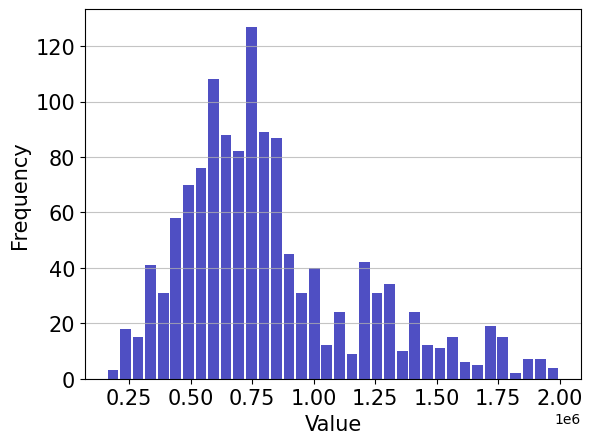

In [262]:
n, bins, patches = plt.hist(x=nyc_df['price'], bins=36, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()



In [263]:
bins

array([ 159000.        ,  210111.11111111,  261222.22222222,
        312333.33333333,  363444.44444444,  414555.55555556,
        465666.66666667,  516777.77777778,  567888.88888889,
        619000.        ,  670111.11111111,  721222.22222222,
        772333.33333333,  823444.44444444,  874555.55555556,
        925666.66666667,  976777.77777778, 1027888.88888889,
       1079000.        , 1130111.11111111, 1181222.22222222,
       1232333.33333333, 1283444.44444444, 1334555.55555556,
       1385666.66666667, 1436777.77777778, 1487888.88888889,
       1539000.        , 1590111.11111111, 1641222.22222222,
       1692333.33333333, 1743444.44444444, 1794555.55555556,
       1845666.66666667, 1896777.77777778, 1947888.88888889,
       1999000.        ])

(array([  5.,  26.,  40.,  43.,  73., 114., 119., 101., 165., 112., 100.,
         43.,  68.,  12.,  24.,  51.,  29.,  36.,  32.,  11.,  14.,  21.,
          3.,  21.,  17.,   4.,  10.,   4.]),
 array([ 159000.        ,  224714.28571429,  290428.57142857,
         356142.85714286,  421857.14285714,  487571.42857143,
         553285.71428571,  619000.        ,  684714.28571429,
         750428.57142857,  816142.85714286,  881857.14285714,
         947571.42857143, 1013285.71428571, 1079000.        ,
        1144714.28571429, 1210428.57142857, 1276142.85714286,
        1341857.14285714, 1407571.42857143, 1473285.71428571,
        1539000.        , 1604714.28571429, 1670428.57142857,
        1736142.85714286, 1801857.14285714, 1867571.42857143,
        1933285.71428571, 1999000.        ]),
 <BarContainer object of 28 artists>)

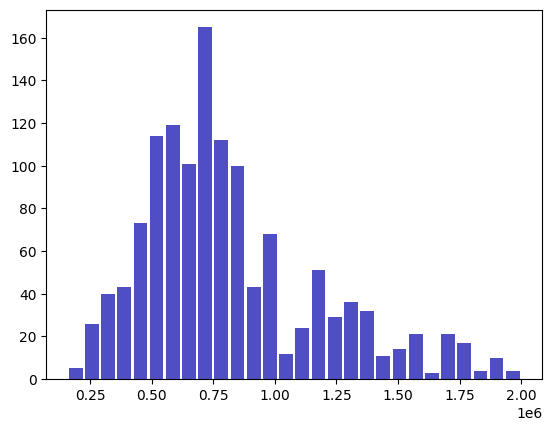

In [264]:
plt.hist(x=nyc_df[nyc_df["price"] < 2000000]["price"], bins=28, color='#0504aa',alpha=0.7, rwidth=0.85)

In [139]:
len(nyc_df[nyc_df["price"] < 2000000])

1307

In [141]:
# Cleaned dataset with outliers removed

nyc_df = nyc_df[nyc_df['price'] < 2000000]

In [143]:
len(nyc_df)

1307

(array([  2.,  16.,  24.,  47.,  62.,  89., 115., 133., 107., 156., 134.,
         60.,  46.,  35.,  26.,  16.,  58.,  42.,  26.,  17.,  14.,  15.,
          7.,  23.,  16.,   5.,  10.,   4.]),
 array([ 120000.        ,  187107.14285714,  254214.28571429,
         321321.42857143,  388428.57142857,  455535.71428571,
         522642.85714286,  589750.        ,  656857.14285714,
         723964.28571429,  791071.42857143,  858178.57142857,
         925285.71428571,  992392.85714286, 1059500.        ,
        1126607.14285714, 1193714.28571429, 1260821.42857143,
        1327928.57142857, 1395035.71428571, 1462142.85714286,
        1529250.        , 1596357.14285714, 1663464.28571429,
        1730571.42857143, 1797678.57142857, 1864785.71428571,
        1931892.85714286, 1999000.        ]),
 <BarContainer object of 28 artists>)

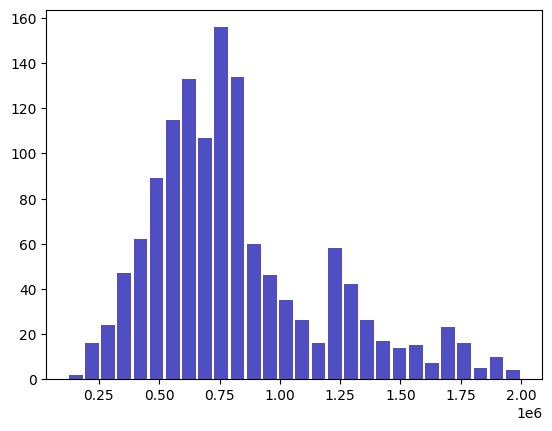

In [91]:
# Final histogram
plt.hist(x=nyc_df["price"], bins=28, color='#0504aa',alpha=0.7, rwidth=0.85)

In [145]:
nyc_df['beds'].unique()

array([ 2,  5,  3,  6,  1,  4,  8,  0, 10,  7,  9, 33, 18, 11],
      dtype=int64)

In [147]:
nyc_df.to_csv('nyc_df.csv', index=False)

In [51]:
nyc_df = pd.read_csv('nyc_df.csv')

In [90]:
nyc_df

,price,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland
0,505000.0,2,3,1000.0,0,1,0,0
1,499900.0,5,2,1998.0,0,1,0,0
2,475000.0,2,1,750.0,0,1,0,0
3,1388888.0,3,4,2298.0,0,1,0,0
4,1188000.0,6,6,2550.0,0,1,0,0
...,...,...,...,...,...,...,...,...
1302,949800.0,3,3,1966.0,1,0,0,0
1303,824999.0,7,2,2100.0,1,0,0,0
1304,919000.0,3,3,1880.0,1,0,0,0
1305,725000.0,3,2,1430.0,1,0,0,0


In [52]:
nyc_df = pd.get_dummies(nyc_df, columns=['borough'], prefix='borough', drop_first=True, dtype=int)

In [104]:
nyc_df

,price,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland
0,505000.0,2,3,1000.0,0,1,0,0
1,499900.0,5,2,1998.0,0,1,0,0
2,475000.0,2,1,750.0,0,1,0,0
3,1388888.0,3,4,2298.0,0,1,0,0
4,1188000.0,6,6,2550.0,0,1,0,0
...,...,...,...,...,...,...,...,...
1302,949800.0,3,3,1966.0,1,0,0,0
1303,824999.0,7,2,2100.0,1,0,0,0
1304,919000.0,3,3,1880.0,1,0,0,0
1305,725000.0,3,2,1430.0,1,0,0,0


In [105]:
X = nyc_df.drop(columns=['price'])

In [106]:
y = nyc_df['price']

Further data cleaning: removing properties with abnormally large area. 

In [100]:
nyc_df = nyc_df[nyc_df['area'] < 10000]

Splitting data into training and testing subsets, and building our linear model.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [108]:
reg = linear_model.LinearRegression().fit(X_train, y_train)

Ensuring the test data set aligns with the cleaned full dataset. 

In [44]:
X_test = X_test[X_test['area'] < 50000]

## Visualizations

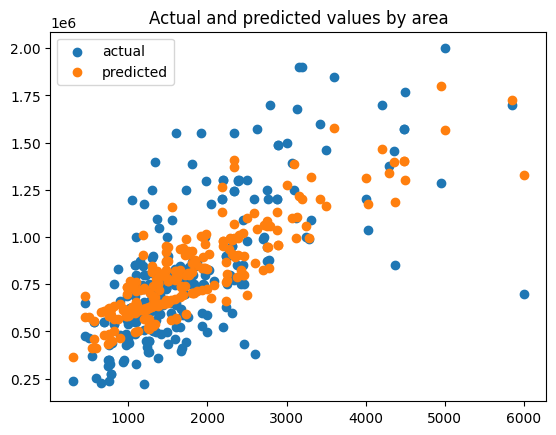

In [109]:
plt.title("Actual and predicted values by area")
plt.scatter(X_test['area'], y_test, label='actual')
plt.scatter(X_test['area'], reg.predict(X_test), label='predicted')
plt.legend()

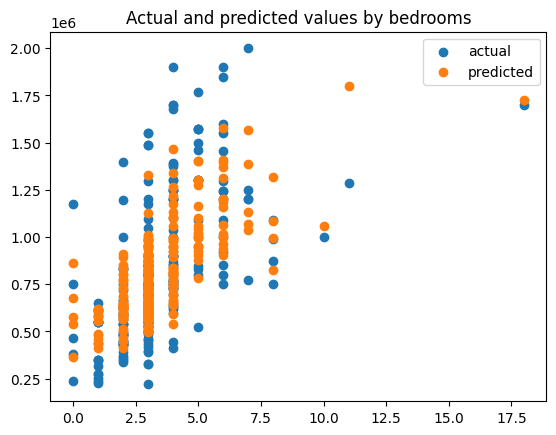

In [110]:
plt.title("Actual and predicted values by bedrooms")
plt.scatter(X_test['beds'], y_test, label='actual')
plt.scatter(X_test['beds'], reg.predict(X_test), label='predicted')
plt.legend()

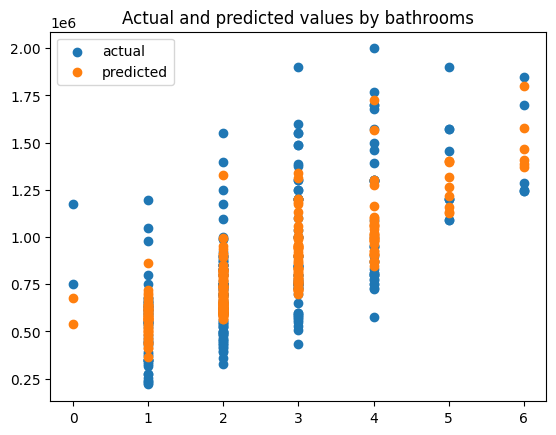

In [111]:
plt.title("Actual and predicted values by bathrooms")
plt.scatter(X_test['baths'], y_test, label='actual')
plt.scatter(X_test['baths'], reg.predict(X_test), label='predicted')
plt.legend()

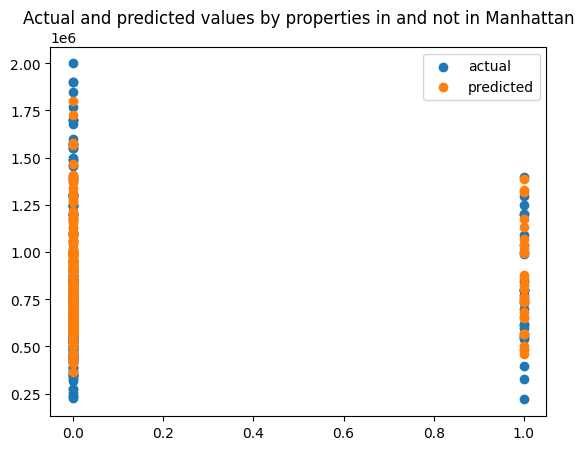

In [112]:
plt.title('Actual and predicted values by properties in and not in Manhattan')
plt.scatter(X_test['borough_manhattan'], y_test, label='actual')
plt.scatter(X_test['borough_manhattan'], reg.predict(X_test), label='predicted')
plt.legend()

The model yields an R-squared value of just over 57%.

In [113]:
print(r2_score(y_test, reg.predict(X_test)))

0.5720067459995937


We can now use the model to determine the expected price of a particular property. Consider the test data set:

In [115]:
prediction_data = X_test


In [116]:
prediction_data

,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland
484,2,1,1045.0,0,0,0,0
727,3,2,1400.0,0,0,0,1
317,2,1,938.0,0,0,0,0
666,5,5,4478.0,0,0,0,1
829,3,1,1079.0,0,0,0,1
...,...,...,...,...,...,...,...
311,3,2,1442.0,0,0,0,0
204,11,6,4950.0,0,0,1,0
301,2,1,754.0,0,0,1,0
291,2,2,1940.0,0,0,1,0


In [117]:
predicted_values = reg.predict(prediction_data)

In [118]:
prediction_data['predicted'] = predicted_values

Below are the predicted prices for each property. We will now add these predicted prices to our prediction dataframe, and add the actual price by joining with the full dataframe.

In [119]:
predicted_values

array([ 630152.76337328,  646463.96346611,  615517.74951793,
       1403664.47180355,  495491.47006058,  823454.86517612,
        592847.83793996,  783348.54633799,  567623.13052085,
        734189.86857786,  824164.55658657,  619439.57296538,
        566586.87849858,  652640.4731213 ,  867328.90621823,
       1564581.38038621,  893215.16480542,  770224.49271359,
        985064.87283077, 1407391.50175051,  719775.8085733 ,
        979492.69042047,  635579.12095539, 1021461.27307448,
        656038.27159578, 1327113.09346526,  799084.19293302,
        734621.4744347 ,  624853.38225915,  622391.41731152,
        619986.67628707,  621178.58015593, 1396177.42776732,
        614890.34392432,  586406.09492376, 1098350.88705879,
        958752.38486455,  782541.92070641, 1082751.60515327,
        691001.35565946,  615005.52246863, 1070652.75134171,
       1579729.04808457,  826791.73188794, 1106967.7643755 ,
        769393.95966687,  764115.75205828,  874276.45018745,
        703362.70892244,

In [120]:
prediction_data['predicted'] = prediction_data['predicted'].apply(lambda x: int(x))

In [121]:
prediction_data

,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland,predicted
484,2,1,1045.0,0,0,0,0,630152
727,3,2,1400.0,0,0,0,1,646463
317,2,1,938.0,0,0,0,0,615517
666,5,5,4478.0,0,0,0,1,1403664
829,3,1,1079.0,0,0,0,1,495491
...,...,...,...,...,...,...,...,...
311,3,2,1442.0,0,0,0,0,799021
204,11,6,4950.0,0,0,1,0,1801881
301,2,1,754.0,0,0,1,0,625123
291,2,2,1940.0,0,0,1,0,894407


In [122]:
prediction_data = prediction_data.merge(nyc_df, how='left')

In [123]:
prediction_data

,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland,predicted,price
0,2,1,1045.0,0,0,0,0,630152,1195000.0
1,3,2,1400.0,0,0,0,1,646463,595000.0
2,2,1,938.0,0,0,0,0,615517,339500.0
3,5,5,4478.0,0,0,0,1,1403664,1575000.0
4,5,5,4478.0,0,0,0,1,1403664,1575000.0
...,...,...,...,...,...,...,...,...,...
301,3,2,1442.0,0,0,0,0,799021,639000.0
302,11,6,4950.0,0,0,1,0,1801881,1288000.0
303,2,1,754.0,0,0,1,0,625123,429000.0
304,2,2,1940.0,0,0,1,0,894407,829000.0


Now it is easy to compare the predicted and actual prices for these properties. From this dataframe we can determine which properties are undervalued or overvalued. 

Let's see just how many potential savings can be discovered from utilizing our model. We will calculate the difference between predicted and actual price for each property in the test data set. 

In [132]:
undervalued = prediction_data[prediction_data['predicted'] > prediction_data['price']]

In [133]:
undervalued['disparity'] = undervalued['price'] - undervalued['predicted']

C:\Users\brand\AppData\Local\Temp\ipykernel_20284\2268743495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued['disparity'] = undervalued['price'] - undervalued['predicted']


In [134]:
undervalued

,beds,baths,area,borough_brooklyn,borough_manhattan,borough_queens,borough_statenisland,predicted,price,disparity
1,3,2,1400.0,0,0,0,1,646463,595000.0,-51463.0
2,2,1,938.0,0,0,0,0,615517,339500.0,-276017.0
6,4,3,1480.0,0,1,0,0,823454,729999.0,-93455.0
8,3,2,1008.0,0,0,0,1,592847,548000.0,-44847.0
10,3,3,1618.0,0,0,0,1,783348,529000.0,-254348.0
...,...,...,...,...,...,...,...,...,...,...
300,4,1,2240.0,1,0,0,0,663761,629995.0,-33766.0
301,3,2,1442.0,0,0,0,0,799021,639000.0,-160021.0
302,11,6,4950.0,0,0,1,0,1801881,1288000.0,-513881.0
303,2,1,754.0,0,0,1,0,625123,429000.0,-196123.0


In [135]:
undervalued['savings_pct'] = abs(undervalued['disparity'] / undervalued['price'] * 100)

C:\Users\brand\AppData\Local\Temp\ipykernel_20284\345939827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued['savings_pct'] = abs(undervalued['disparity'] / undervalued['price'] * 100)


In [138]:
undervalued['savings_pct'].mean()

30.07948325045931

Average disparity (as a percentage) between actual price and predicted price

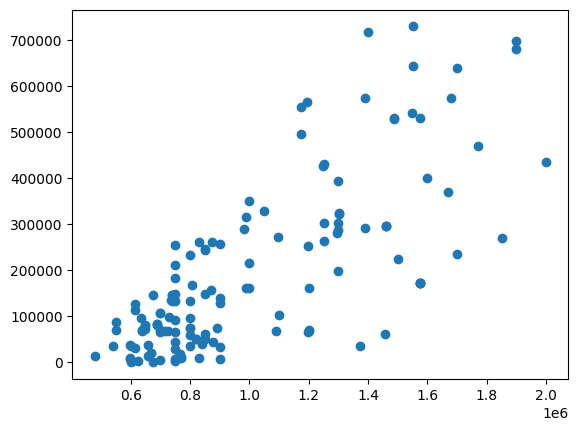

In [129]:
plt.scatter(undervalued['price'], undervalued['disparity'])

Distribution of disparity by price per property.

In [144]:
undervalued['savings_pct'].max()

164.79913490132466

Maximum savings possible.